In [1]:
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import torch

from environments.onestep import ARESEAOneStep
from onestep import GaussianActor, Simulation

initializing ocelot...


## Bayesian Optimisation

In [2]:
env = ARESEAOneStep()
observation = env.reset()
before = env.segment.AREABSCR1.reading

In [3]:
def objective_fn(q1, q2, q3, cv, ch):
    action = np.array([q1, q2, q3, cv, ch])
    _, reward, _, _ = env.step(action)
    return reward

In [4]:
pbounds = {"q1": (-1,1), "q2": (-1,1), "q3": (-1,1), "cv": (-1,1), "ch": (-1,1)}

In [5]:
optimizer = BayesianOptimization(
    f=objective_fn,
    pbounds=pbounds
)
optimizer.maximize(init_points=3, n_iter=50-3)

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  4.969    |  0.9894   |  0.7641   |  0.8099   | -0.8258   |  0.8547   |
|  2        |  3.973    |  0.763    | -0.781    |  0.9276   | -0.01737  |  0.3355   |
|  3        |  2.862    | -0.04679  |  0.9612   | -0.5067   | -0.2719   | -0.6948   |
|  4        |  4.909    |  0.9647   |  0.4733   |  0.8538   | -0.6534   |  0.7708   |
|  5        |  3.198    |  1.0      |  1.0      |  1.0      |  1.0      |  1.0      |
|  6        |  4.816    | -0.1678   |  0.4588   |  1.0      | -1.0      |  1.0      |
|  7        |  3.861    |  1.0      | -0.3043   | -0.4044   | -1.0      |  1.0      |
|  8        |  4.047    | -1.0      | -1.0      |  1.0      | -1.0      |  1.0      |
|  9        |  3.021    |  1.0      |  0.7906   |  1.0      | -1.0      | -0.135    |
|  10       |  5.606    |  0.4123   |  0.6101   |  0.6

Desired: [-1.3247726e-03  7.1800320e-04  9.4300776e-05  1.8888777e-04]
Objective: 6.928036357392659


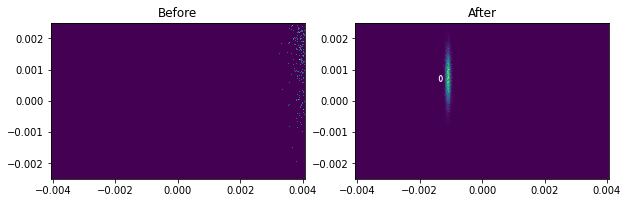

In [6]:
print("Desired:", env.desired)

screen = env.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

_, reward, _, _ = env.step(np.array([
    optimizer.max["params"]["q1"],
    optimizer.max["params"]["q2"],
    optimizer.max["params"]["q3"],
    optimizer.max["params"]["cv"],
    optimizer.max["params"]["ch"]
]))
print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

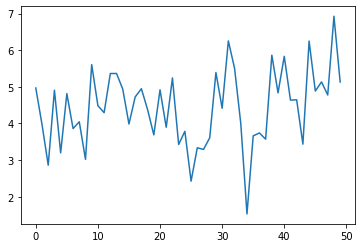

In [7]:
plt.plot(optimizer.space.target)
plt.show()

In [8]:
simulation = Simulation()
simulation.reset(incoming=env.incoming, initial_actuators=env.initial_actuators, desired=env.desired)

array([ 2.5910077e+00,  7.9564586e+00,  2.9757881e+01,  1.7247422e-04,
        4.2377235e-03, -1.3247726e-03,  7.1800320e-04,  9.4300776e-05,
        1.8888777e-04,  5.0085862e-03,  2.4738766e-03,  5.0729653e-04,
        1.8656972e-03], dtype=float32)

In [9]:
def target_fn(q1, q2, q3, cv, ch):
    normalized_actuators = np.array([q1, q2, q3, cv, ch])
    actuators = normalized_actuators * simulation.actuator_space.high
    
    achieved = simulation.track(actuators)
    
    def objective_fn(achieved, desired):
        offset = achieved - desired
        weights = np.array([1, 1, 2, 2])

        return -np.log((weights * np.abs(offset)).sum())
    
    return objective_fn(achieved, simulation.desired)

In [10]:
pbounds = {"q1": (-1,1), "q2": (-1,1), "q3": (-1,1), "cv": (-1,1), "ch": (-1,1)}

In [11]:
optimizer = BayesianOptimization(
    f=target_fn,
    pbounds=pbounds
)
optimizer.maximize(init_points=3, n_iter=50-3)

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  3.922    | -0.4315   | -0.851    |  0.177    | -0.6866   | -0.7996   |
|  2        |  2.902    |  0.6607   |  0.93     | -0.4173   | -0.6613   | -0.3652   |
|  3        |  4.421    | -0.2437   |  0.8967   |  0.5068   | -0.5532   | -0.1298   |
|  4        |  3.986    |  0.2512   |  0.2826   |  0.5308   |  0.5753   |  0.9974   |
|  5        |  3.027    |  0.989    | -0.01252  | -0.4159   | -0.7882   | -0.1589   |
|  6        |  4.089    | -0.3862   |  0.6865   |  0.7751   | -0.169    |  0.25     |
|  7        |  3.144    | -0.8012   |  0.9787   |  0.8584   | -0.8619   | -0.4403   |
|  8        |  4.487    | -0.03947  |  0.9851   |  0.4972   | -0.3613   |  0.1649   |
|  9        |  4.918    | -0.4674   |  1.0      |  0.03823  | -0.3621   |  0.2787   |
|  10       |  5.083    | -0.4768   |  1.0      |  0.0

Desired: [-1.3247726e-03  7.1800320e-04  9.4300776e-05  1.8888777e-04]
Objective: 7.962464502639209


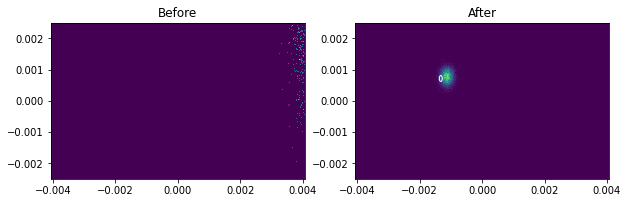

In [12]:
print("Desired:", env.desired)

screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

objective = target_fn(**optimizer.max["params"])

print("Objective:", objective)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

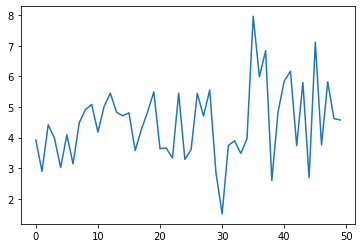

In [13]:
plt.plot(optimizer.space.target)
plt.show()

## Reinforcement Learning

In [15]:
timestamp = "20210908093749"
model = torch.load(f"models/onestep_vpg/onestep-model-{timestamp}.pkl")

Objective: 8.305374506214013


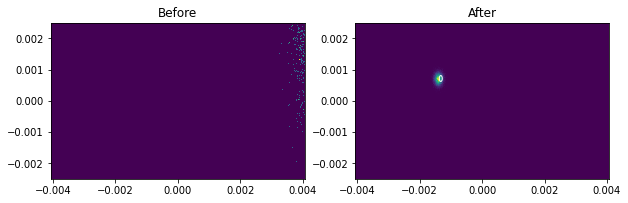

In [16]:
screen = env.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

torched_observation = torch.tensor(observation, dtype=torch.float32)
unsqueezed_observation = torched_observation.unsqueeze(0)
unsqueezed_actuators = model(unsqueezed_observation).sample()
torched_actuators = unsqueezed_actuators.squeeze()
actuators = torched_actuators.detach().numpy()
_, reward, _, _ = env.step(actuators)

print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

In [17]:
simulation = Simulation()
simulation.reset(incoming=env.incoming, initial_actuators=env.initial_actuators, desired=env.desired)

array([ 2.5910077e+00,  7.9564586e+00,  2.9757881e+01,  1.7247422e-04,
        4.2377235e-03, -1.3247726e-03,  7.1800320e-04,  9.4300776e-05,
        1.8888777e-04,  5.0085862e-03,  2.4738766e-03,  5.0729653e-04,
        1.8656972e-03], dtype=float32)

Objective: 8.305374506214013


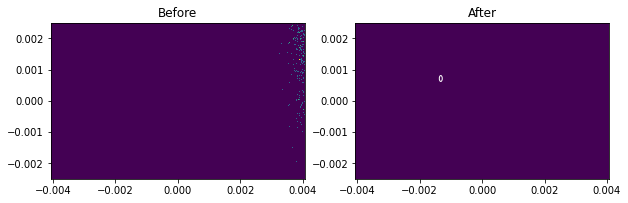

In [18]:
screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

observation_factor = np.concatenate([
    simulation.actuator_space.high,
    simulation.goal_space.high,
    simulation.goal_space.high
])

normalized_observation = observation / observation_factor
normalized_observation = torch.tensor(normalized_observation, dtype=torch.float32)
unsqueezed_observation = normalized_observation.unsqueeze(0)

unsqueezed_actuators = model(unsqueezed_observation).sample()

normalized_actuators = unsqueezed_actuators.squeeze()
actuators = normalized_actuators.detach().numpy() * simulation.actuator_space.high

simulation.track(actuators)

print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = simulation.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

## Bla bla

In [19]:
simulation = Simulation()
sobservation = simulation.reset()

env = ARESEAOneStep()
eobservation = env.reset(
    incoming=simulation.incoming,
    initial_actuators=simulation.initial_actuators,
    desired=simulation.desired
)

print("Simulation:", sobservation)
print("Environment:", eobservation)

Simulation: [-1.3914580e+00 -8.6917009e+00  1.1059527e+01  1.5768153e-03
  2.8975492e-03 -1.8986245e-03 -4.8392182e-04  2.9359368e-04
  5.0233688e-05  4.5006434e-03  1.8459097e-03  4.2790661e-04
  1.8599165e-04]
Environment: [-0.04638194 -0.28972337  0.3686509   0.5256051   0.48292485 -0.9493122
 -0.2419609   0.58718735  0.10046737  2.2503216   0.92295486  0.85581315
  0.3719833 ]
